# SP500 vs VTI

In [118]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import japanize_matplotlib
import seaborn as sns
import scipy.stats as stats

import yfinance as yf

az.style.use('arviz-darkgrid')

In [3]:
df = pd.DataFrame()
df['sp'] = yf.download("VOO")['Close']
df['vti'] = yf.download("VTI")['Close']
df = df.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# add log returns
df['sp_log'] = np.log(df['sp'])
df['vti_log'] = np.log(df['vti'])
df['sp_lr'] = df['sp_log'].diff()
df['vti_lr'] = df['vti_log'].diff()
df.iloc[0, df.columns.get_loc('sp_lr')] = 0 # set first value to 0
df.iloc[0, df.columns.get_loc('vti_lr')] = 0
df['sp_cum_log'] = df['sp_lr'].cumsum()
df['vti_cum_log'] = df['vti_lr'].cumsum()
df['sp_cum'] = (np.exp(df['sp_cum_log']) - 1) * 100
df['vti_cum'] = (np.exp(df['vti_cum_log']) - 1) * 100
df['sp_lr_annual'] = df['sp_lr'] * 252
df['vti_lr_annual'] = df['vti_lr'] * 252

In [ ]:
df

,sp,vti,sp_log,vti_log,sp_lr,vti_lr,sp_cum_log,vti_cum_log,sp_cum,vti_cum,sp_lr_annual,vti_lr_annual
Date,,,,,,,,,,,,
2010-09-09,77.721313,43.471176,4.353130,3.772098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-09-10,78.074211,43.655983,4.357660,3.776340,0.004530,0.004242,0.004530,0.004242,0.454055,0.425125,1.141629,1.069044
2010-09-13,79.056053,44.210453,4.370157,3.788961,0.012497,0.012621,0.017028,0.016863,1.717341,1.700614,3.149329,3.180471
2010-09-14,79.040749,44.202755,4.369964,3.788787,-0.000194,-0.000174,0.016834,0.016689,1.697649,1.682906,-0.048790,-0.043883
2010-09-15,79.240158,44.349068,4.372483,3.792092,0.002520,0.003305,0.019354,0.019994,1.954219,2.019480,0.634962,0.832752
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,543.300964,292.339020,6.297663,5.677914,0.011255,0.011316,1.944534,1.905816,599.037291,572.489327,2.836230,2.851603
2024-12-23,547.190002,294.000000,6.304796,5.683580,0.007133,0.005666,1.951667,1.911482,604.041116,576.310204,1.797432,1.427734
2024-12-24,552.820007,297.119995,6.315032,5.694136,0.010236,0.010556,1.961903,1.922038,611.284952,583.487362,2.579565,2.660191


Text(0, 0.5, 'Difference in Cumulative Return (%)')

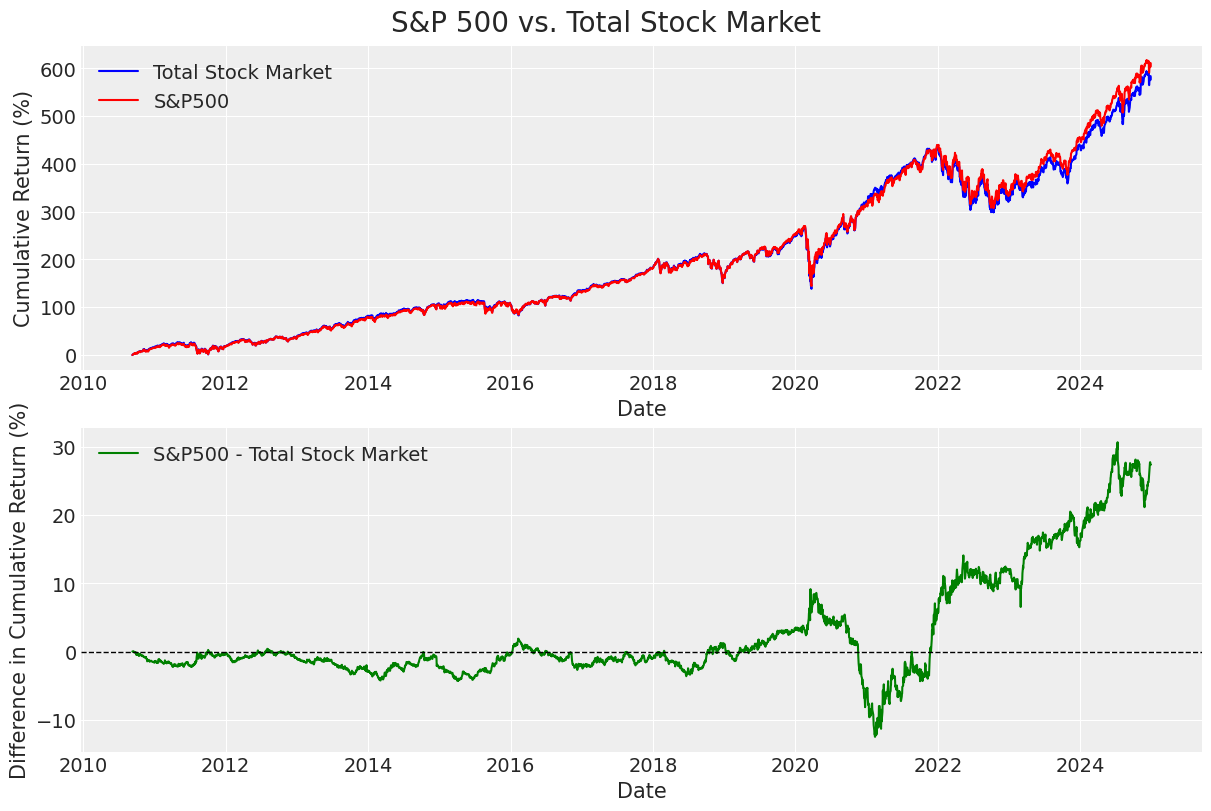

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))

fig.suptitle('S&P 500 vs. Total Stock Market', fontsize=20)
sns.lineplot(df['vti_cum'], label='Total Stock Market', color='blue', ax=ax[0])
sns.lineplot(df['sp_cum'], label='S&P500', color='red', ax=ax[0])
ax[0].set_ylabel('Cumulative Return (%)')

diff = df['sp_cum'] - df['vti_cum']
sns.lineplot(diff, label='S&P500 - Total Stock Market', color='green', ax=ax[1])
ax[1].axhline(0, color='black', lw=1, ls='--')
ax[1].set_ylabel('Difference in Cumulative Return (%)')


<Axes: xlabel='vti_lr_annual', ylabel='Density'>

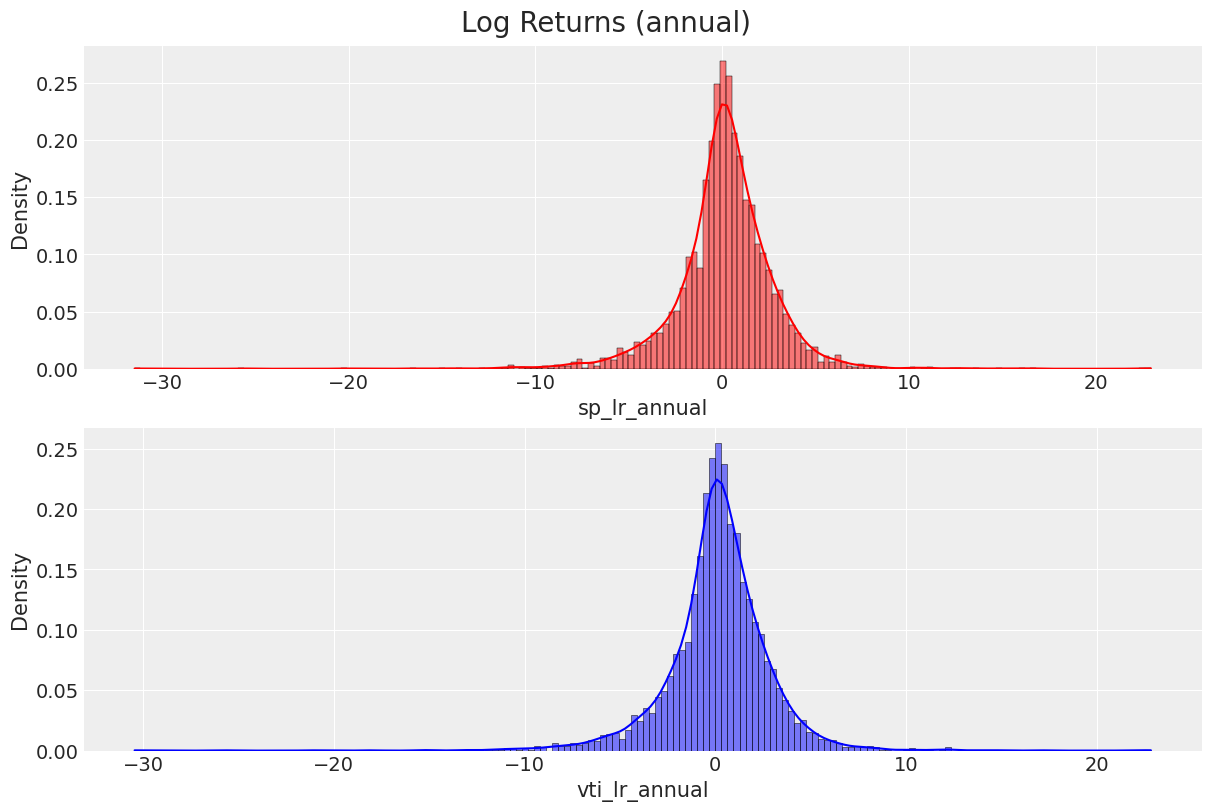

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))
fig.suptitle('Log Returns (annual)', fontsize=20)
sns.histplot(df['sp_lr_annual'], kde=True, stat='density', color='red', ax=ax[0])
sns.histplot(df['vti_lr_annual'], kde=True, stat='density', color='blue', ax=ax[1])


## グループ比較

$$
\begin{aligned}
Y_{1t} &\sim \mathcal{t}(\nu, \mu+\delta, (\sigma+\tau)^2) \\
Y_{2t} &\sim \mathcal{t}(\nu, \mu-\delta, (\sigma-\tau)^2) \\
\mu &\sim \mathcal{N}(0.135, 0.1) \\
\delta &\sim \mathcal{N}(0, 1) \\
\sigma^2 &\sim \text{Inv-Gamma}(1, 1) \\
\tau &\sim \mathcal{N}(0, 1) \\
\nu &\sim \mathcal{Exponential}(1/10) \\
\end{aligned}
$$

In [8]:
sp_vol = np.std(df['sp_lr'])
vti_vol = np.std(df['vti_lr'])
sp_vol_annual = sp_vol * np.sqrt(252)
vti_vol_annual = vti_vol * np.sqrt(252)

sp_vol, vti_vol, sp_vol_annual, vti_vol_annual

(0.010754545402046716,
 0.01093693341557973,
 0.1707231155842126,
 0.1736184355397772)

In [9]:
mean_sp_vti = np.mean(df['sp_lr_annual'] + df['vti_lr_annual']) / 2
sigma = (sp_vol_annual + vti_vol_annual) / 2

In [10]:
mean_sp_vti

0.1352114858062848

In [32]:
with pm.Model() as model:
    # data
    voo = pm.MutableData('voo', df['sp_lr_annual'])
    vti = pm.MutableData('vti', df['vti_lr_annual'])

    # priors
    mu = pm.Normal('mu', mu=0.135, sigma=0.1)
    delta = pm.Normal('delta', mu=0, sigma=0.1)
    sigma = pm.InverseGamma('sigma', alpha=1, beta=1)
    tau = pm.Normal('tau', mu=0, sigma=0.1)
    nu = pm.Exponential('nu', lam=1/10)

    # likelihood
    y_voo = pm.StudentT('y_voo', nu=nu, mu=mu+delta, sigma=sigma+tau, observed=voo)
    y_vti = pm.StudentT('y_vti', nu=nu, mu=mu-delta, sigma=sigma-tau, observed=vti)


In [33]:
model

   mu ~ Normal(0.135, 0.1)
delta ~ Normal(0, 0.1)
sigma ~ InverseGamma(1, 1)
  tau ~ Normal(0, 0.1)
   nu ~ Exponential(f())
y_voo ~ StudentT(nu, f(mu, delta), f(sigma, tau))
y_vti ~ StudentT(nu, f(mu, delta), f(sigma, tau))

In [ ]:
graph = pm.model_to_graphviz(model)
graph.render('model', format='png')

In [11]:
with model:
    trace = pm.sample(2000, tune=1000, chains=4, nuts_sampler='numpyro', random_seed=42)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [36]:
az.summary(trace, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,0.236,0.023,0.195,0.280
delta,-0.004,0.023,-0.048,0.036
tau,-0.024,0.019,-0.059,0.011
sigma,1.612,0.027,1.560,1.661
nu,2.781,0.111,2.580,2.999


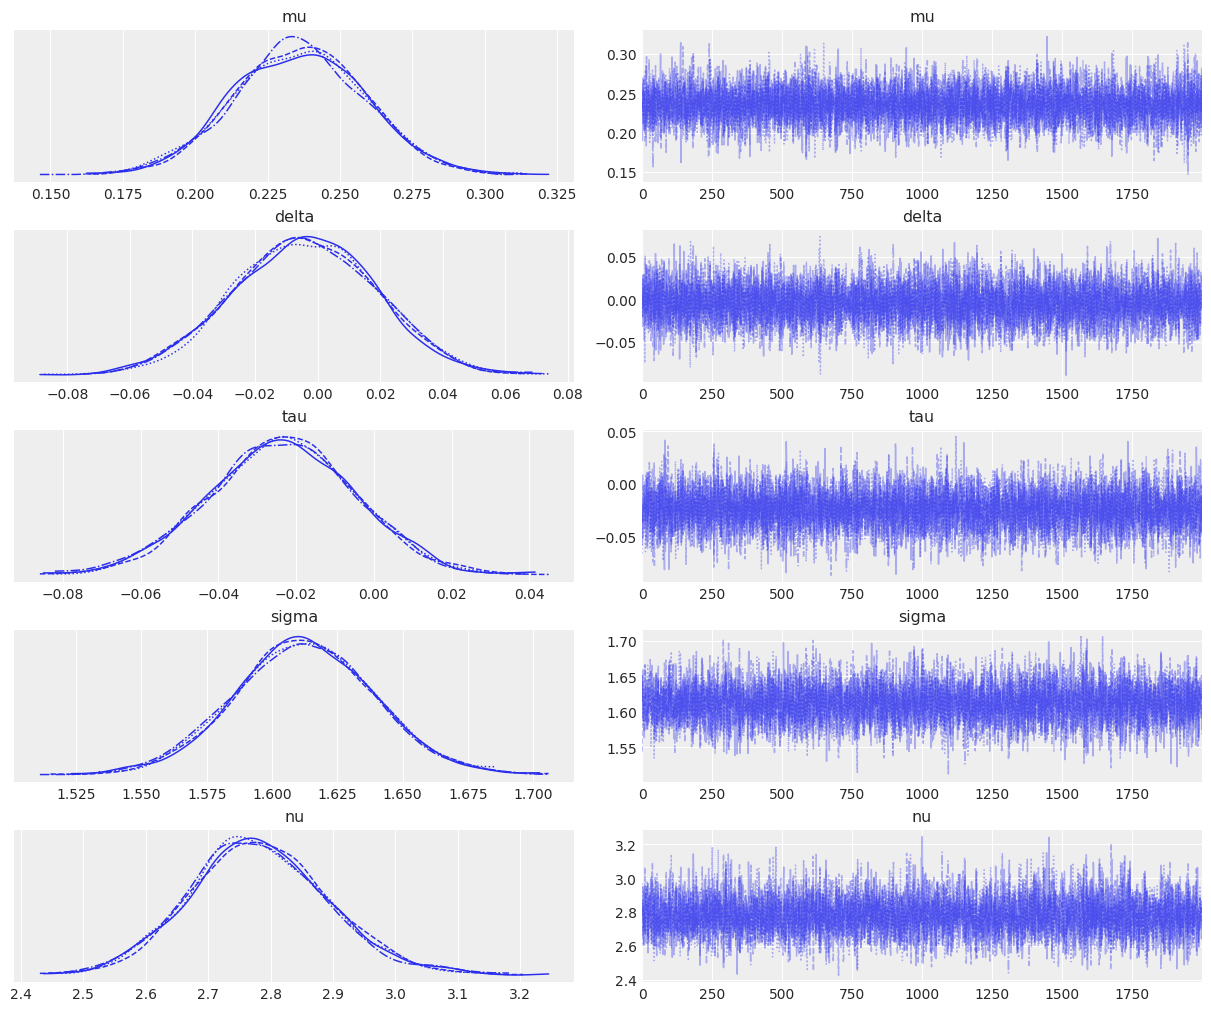

In [13]:
az.plot_trace(trace);

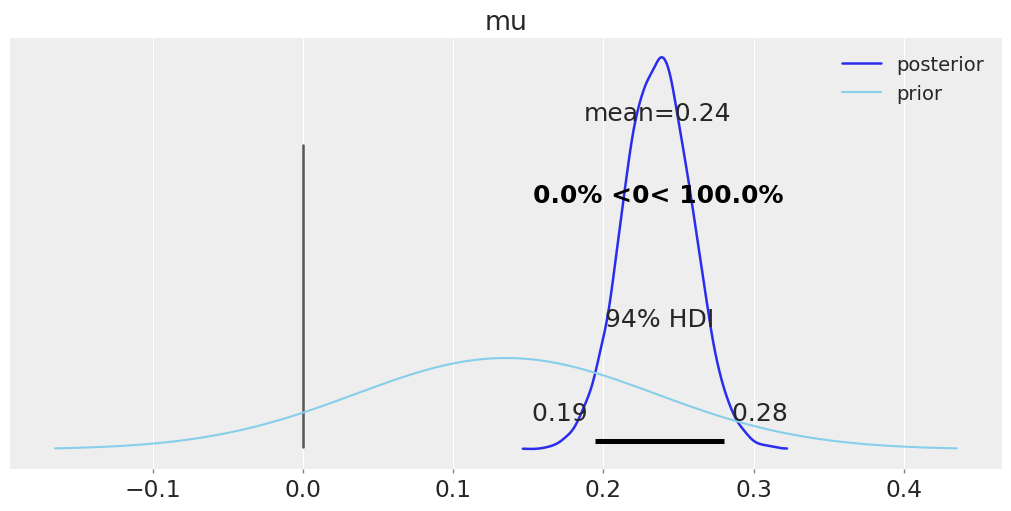

In [15]:
az.plot_posterior(trace, var_names=['mu'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior')
mu = 0.135
sigma = 0.1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

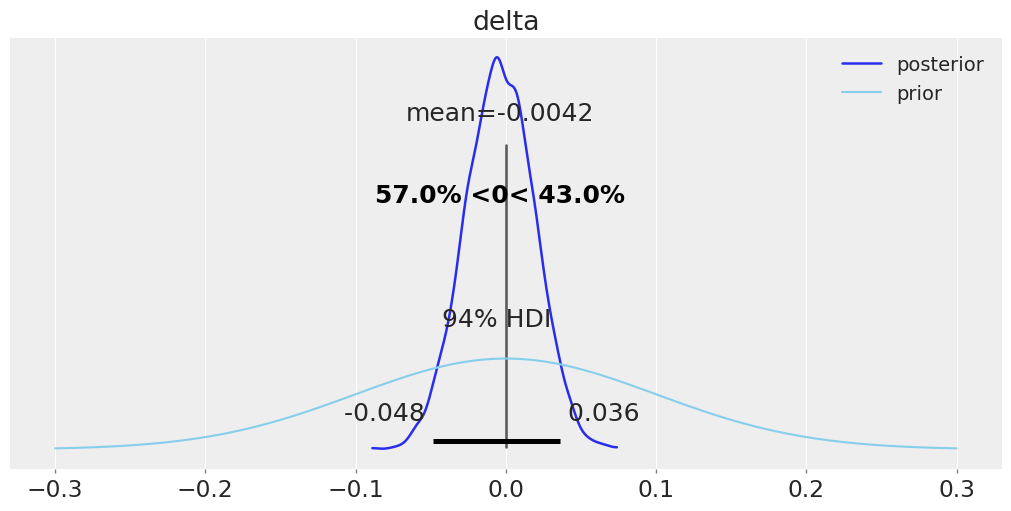

In [16]:
az.plot_posterior(trace, var_names=['delta'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior', )
mu = 0
sigma = 0.1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

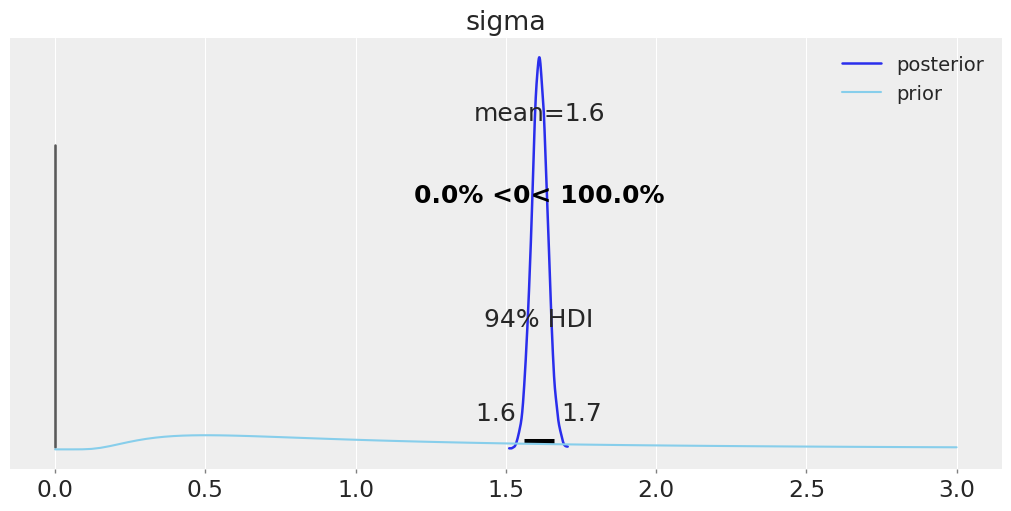

In [44]:
az.plot_posterior(trace, var_names=['sigma'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior')
a = 1
b = 1
scale = 1/b
x = np.linspace(start=0, stop=3*scale, num=100)
pdf = stats.invgamma.pdf(x=x, a=a, scale=scale)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

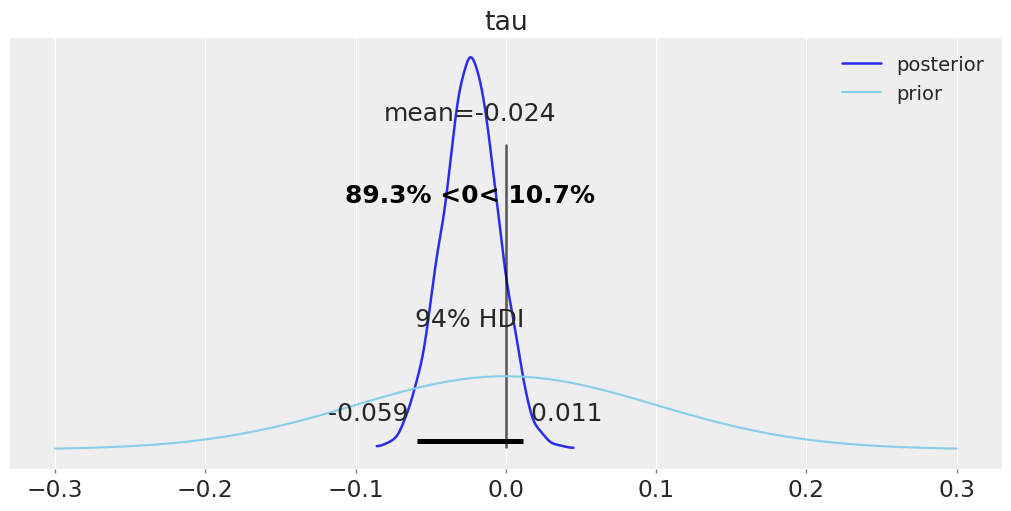

In [18]:
az.plot_posterior(trace, var_names=['tau'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior')
mu = 0
sigma = 0.1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

In [19]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling: [y_voo, y_vti]


Output()

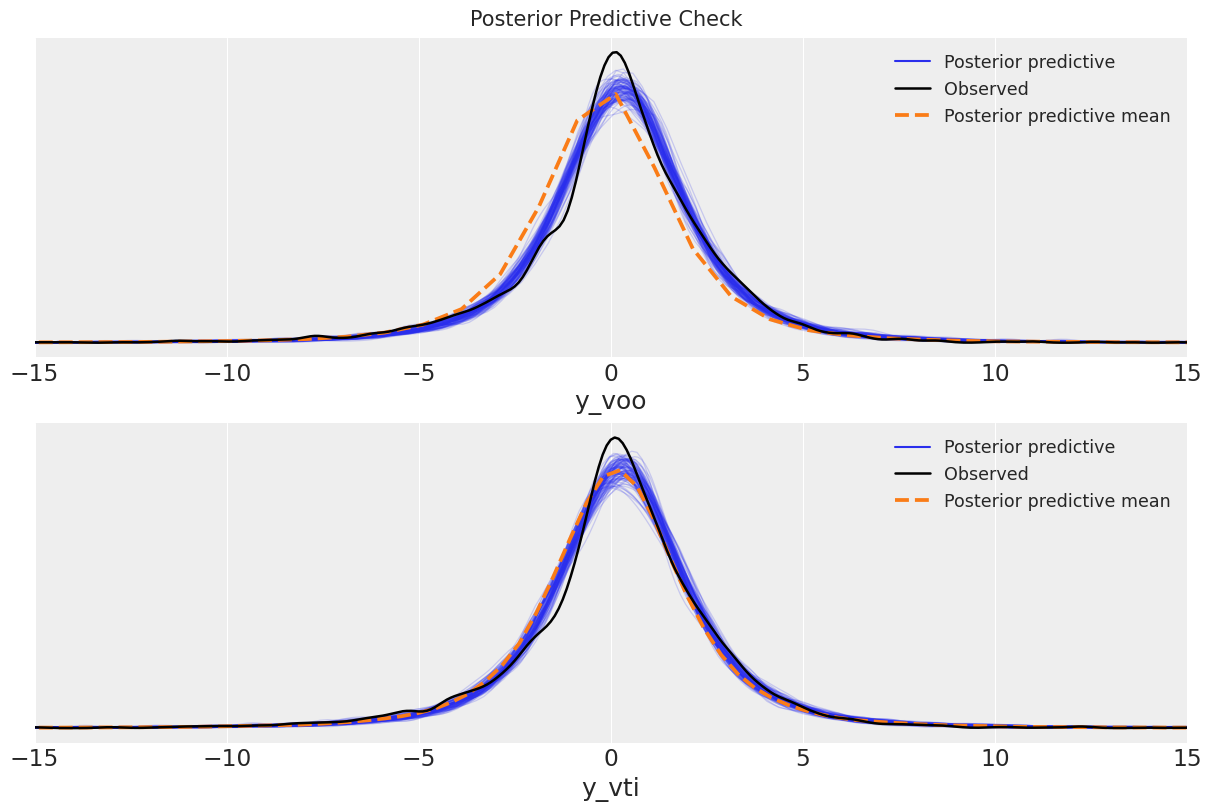

In [20]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))
fig.suptitle('Posterior Predictive Check', fontsize=15)
az.plot_ppc(trace, var_names='y_voo', num_pp_samples=100, figsize=(10, 5), ax=ax[0])
ax[0].set_xlim(-15, 15)
az.plot_ppc(trace, var_names='y_vti', num_pp_samples=100, figsize=(10, 5), ax=ax[1])
ax[1].set_xlim(-15, 15)
plt.show()

## Normal

In [14]:
with pm.Model() as model_n:
    # data
    voo = pm.MutableData('voo', df['sp_lr_annual'])
    vti = pm.MutableData('vti', df['vti_lr_annual'])

    # priors
    mu = pm.Normal('mu', mu=0.135, sigma=0.1)
    delta = pm.Normal('delta', mu=0, sigma=0.1)
    sigma = pm.InverseGamma('sigma', alpha=1, beta=1)
    tau = pm.Normal('tau', mu=0, sigma=0.1)

    # likelihood
    y_voo = pm.Normal('y_voo', mu=mu+delta, sigma=sigma+tau, observed=voo)
    y_vti = pm.Normal('y_vti', mu=mu-delta, sigma=sigma-tau, observed=vti)


/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/data.py:321: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [17]:
model_n

   mu ~ Normal(0.135, 0.1)
delta ~ Normal(0, 0.1)
sigma ~ InverseGamma(1, 1)
  tau ~ Normal(0, 0.1)
y_voo ~ Normal(f(mu, delta), f(sigma, tau))
y_vti ~ Normal(f(mu, delta), f(sigma, tau))

In [16]:
graph = pm.model_to_graphviz(model_n)
graph.render('model_n', format='png')

'model_n.png'

In [23]:
with model_n:
    trace_n = pm.sample(2000, tune=1000, chains=4, nuts_sampler='numpyro', random_seed=42)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [37]:
az.summary(trace_n, kind='stats')

,mean,sd,hdi_3%,hdi_97%
mu,0.135,0.031,0.077,0.193
delta,0.001,0.031,-0.059,0.057
tau,-0.022,0.022,-0.066,0.018
sigma,2.734,0.023,2.689,2.776


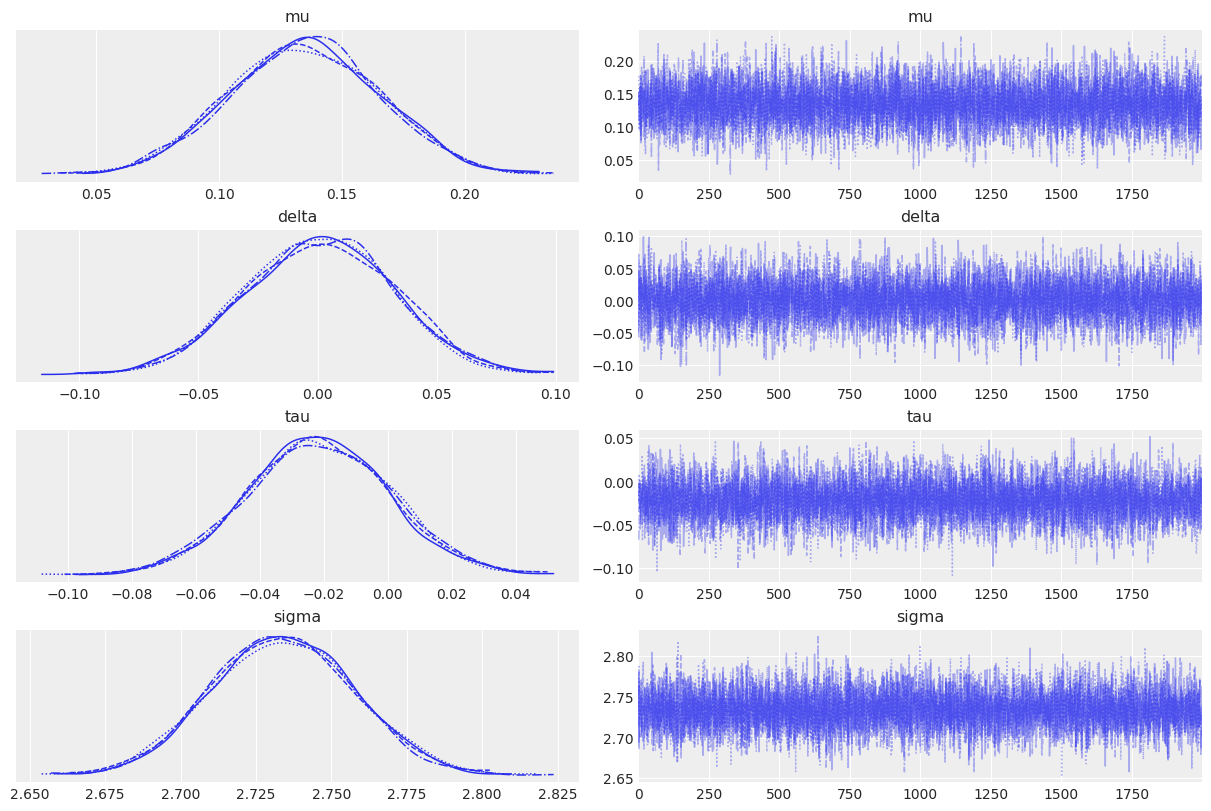

In [26]:
az.plot_trace(trace_n);

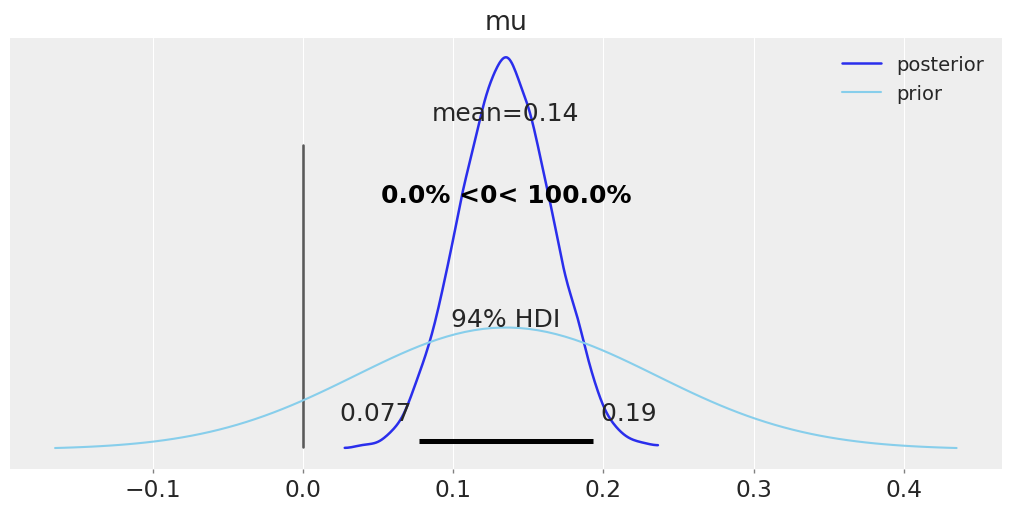

In [34]:
az.plot_posterior(trace_n, var_names=['mu'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior')
mu = 0.135
sigma = 0.1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

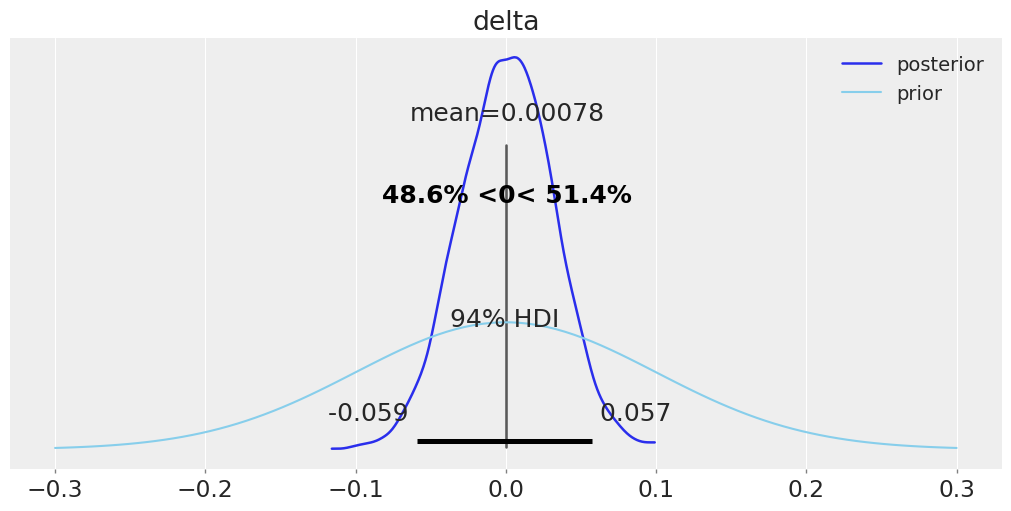

In [33]:
az.plot_posterior(trace_n, var_names=['delta'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior', )
mu = 0
sigma = 0.1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

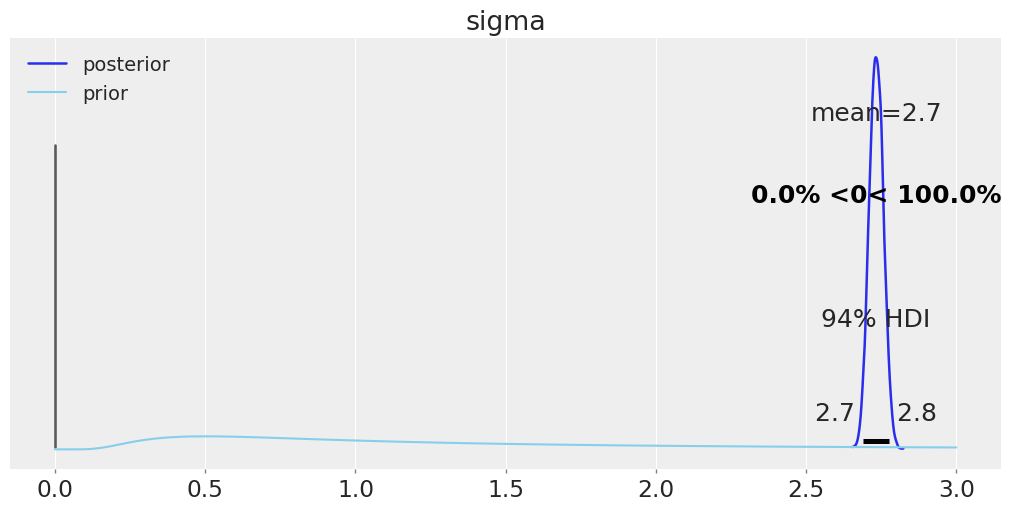

In [46]:
az.plot_posterior(trace_n, var_names=['sigma'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior')
a = 1
beta = 1
scale = 1/beta
x = np.linspace(start=0, stop=3*scale, num=100)
pdf = stats.invgamma.pdf(x=x, a=a, scale=scale)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

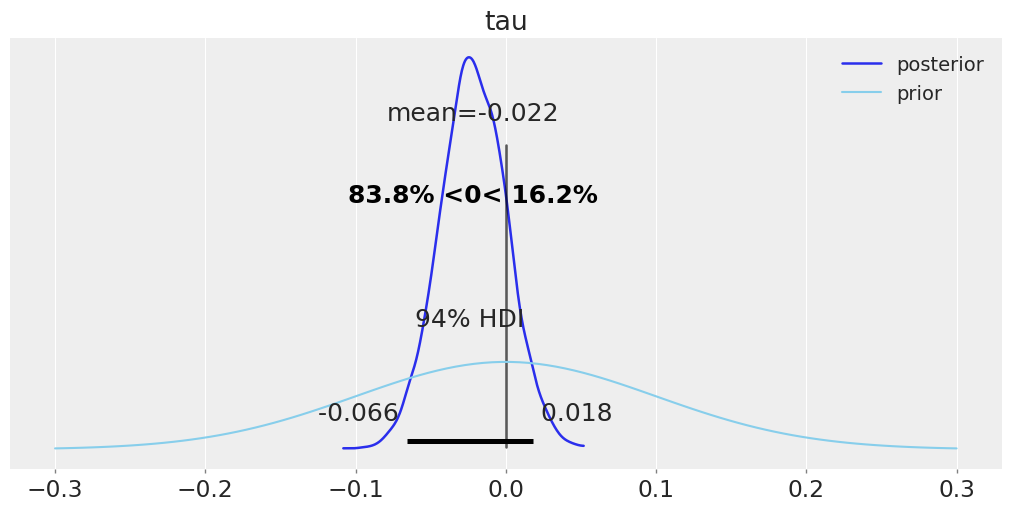

In [31]:
az.plot_posterior(trace_n, var_names=['tau'], ref_val=0, ref_val_color='black', figsize=(10, 5), label='posterior')
mu = 0
sigma = 0.1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, label='prior', color='skyblue')
plt.legend()

In [35]:
with model_n:
    pm.sample_posterior_predictive(trace_n, extend_inferencedata=True)

Sampling: [y_voo, y_vti]


Output()

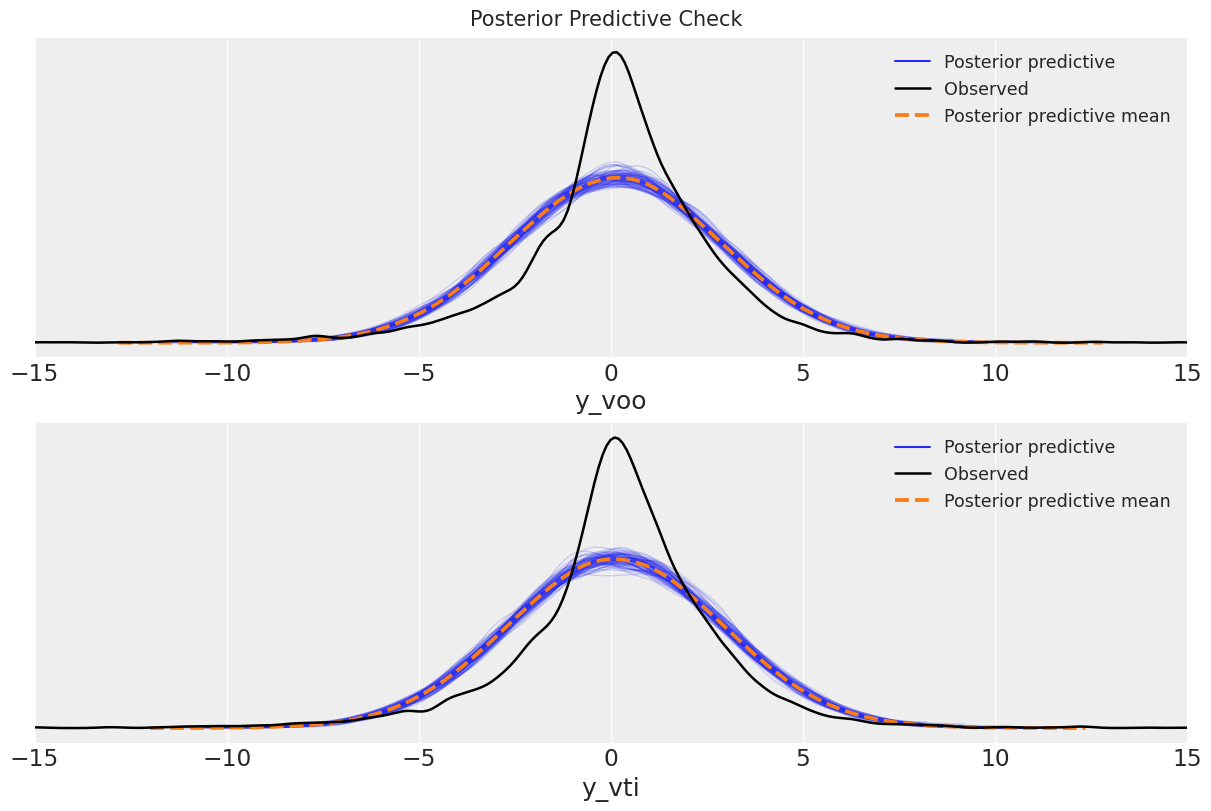

In [36]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))
fig.suptitle('Posterior Predictive Check', fontsize=15)
az.plot_ppc(trace_n, var_names='y_voo', num_pp_samples=100, figsize=(10, 5), ax=ax[0])
ax[0].set_xlim(-15, 15)
az.plot_ppc(trace_n, var_names='y_vti', num_pp_samples=100, figsize=(10, 5), ax=ax[1])
ax[1].set_xlim(-15, 15)
plt.show()

## 比較

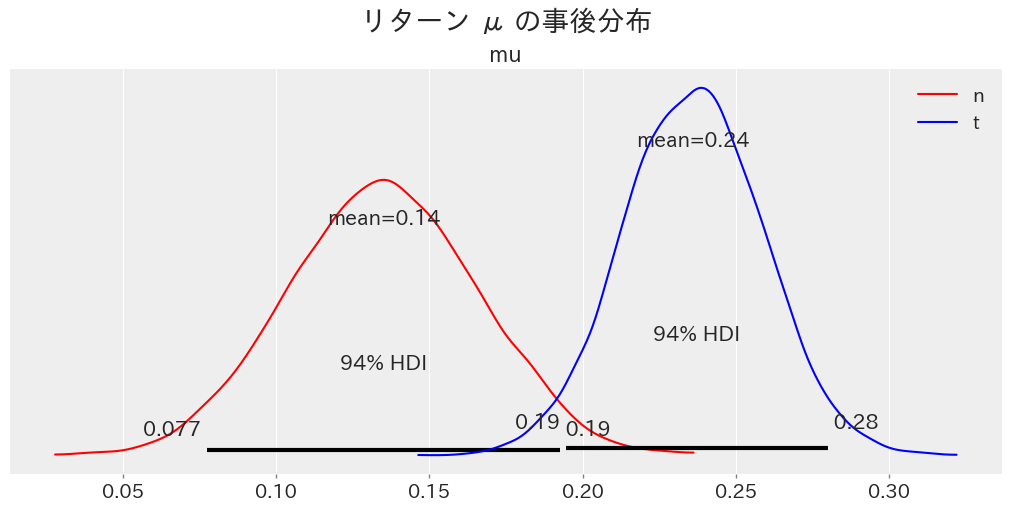

In [175]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('リターン μ の事後分布', fontsize=20)

az.plot_posterior(trace_n, var_names=['mu'], color='red', label='n', ax=ax)
az.plot_posterior(trace, var_names=['mu'], color='blue', label='t', ax=ax)

plt.legend()
plt.show()

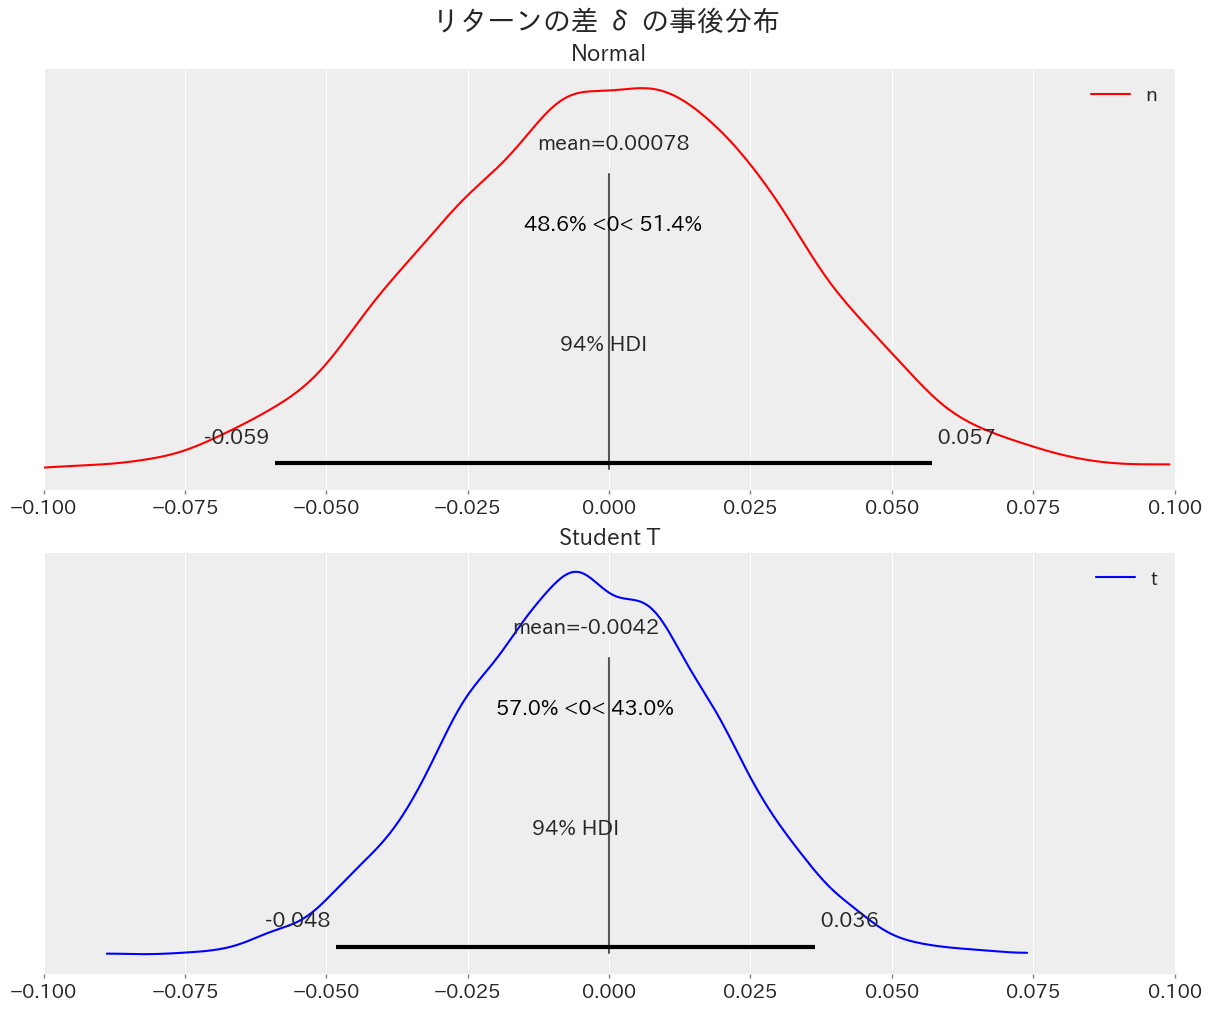

In [181]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 10))
fig.suptitle('リターンの差 δ の事後分布', fontsize=20)

az.plot_posterior(trace_n, var_names=['delta'], ref_val=0, ref_val_color='black', color='red', label='n', ax=ax[0])
ax[0].set_title('Normal')
ax[0].set_xlim(-0.1, 0.1)

az.plot_posterior(trace, var_names=['delta'], ref_val=0, ref_val_color='black', color='blue', label='t', ax=ax[1])
ax[1].set_title('Student T')
ax[1].set_xlim(-0.1, 0.1)

plt.legend()
plt.show()

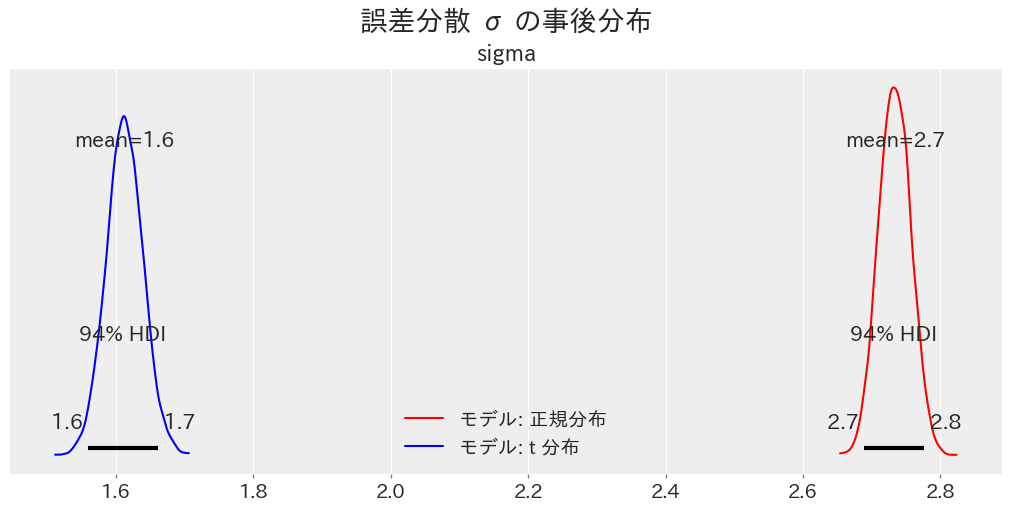

In [180]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('誤差分散 σ の事後分布', fontsize=20)

az.plot_posterior(trace_n, var_names=['sigma'], color='red', label='モデル: 正規分布', ax=ax)
az.plot_posterior(trace, var_names=['sigma'], color='blue', label='モデル: t 分布', ax=ax)


plt.legend()
plt.show()

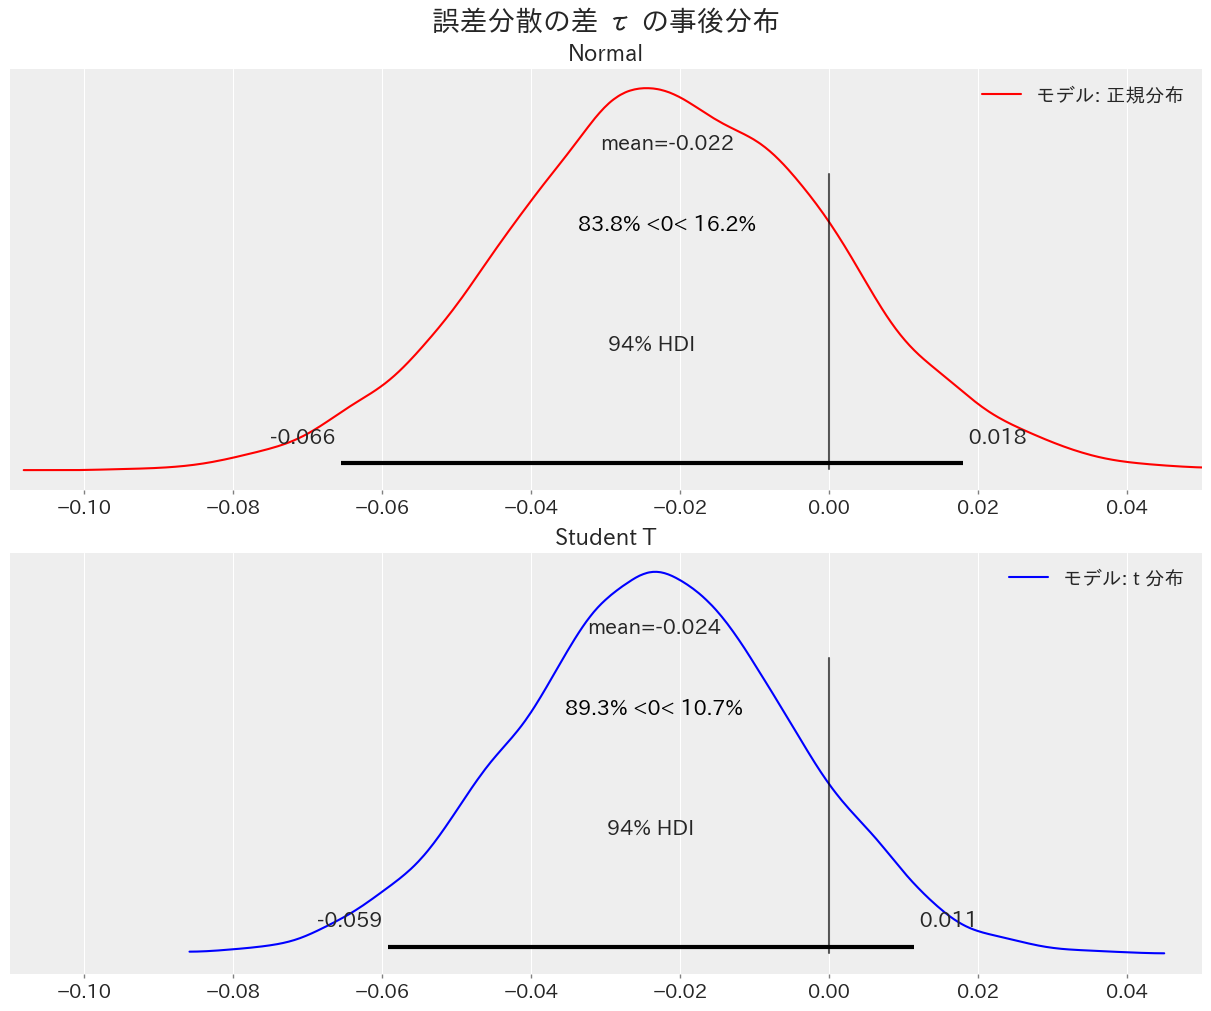

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12, 10))
fig.suptitle('誤差分散の差 τ の事後分布', fontsize=20)

az.plot_posterior(trace_n, var_names=['tau'], ref_val=0, ref_val_color='black', color='red', label='モデル: 正規分布', ax=ax[0])
ax[0].set_title('Normal')
ax[0].set_xlim(-0.11, 0.05)

az.plot_posterior(trace, var_names=['tau'], ref_val=0, ref_val_color='black', color='blue', label='モデル: t 分布', ax=ax[1])
ax[1].set_title('Student T')
ax[1].set_xlim(-0.11, 0.05)

plt.legend()
plt.show()

## save mcmc samples

In [47]:
az.to_netcdf(trace_n, './mcmc_samples/trace_n.nc')
az.to_netcdf(trace, 'trace.nc')

'trace.nc'

In [57]:
# import mcmc samples
trace_n = az.from_netcdf('./mcmc_samples/trace_n.nc')
trace = az.from_netcdf('./mcmc_samples/trace.nc')